# Weather forecast
We will predict upcomming events for current day of Austin City by feeding the model with data about
* Temperature
* Dew point temperature
* Humidity percentage
* Sea level pressure
* Visibility
* Wind speed
* Percipitation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

### Get data (X) and events (y) from CSV file

In [2]:
df = pd.read_csv('data_input/austin_weather.csv')
df.set_index('Date').sort_index()

# use average data only
columns_of_interest = ['TempAvgF','DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH', 'PrecipitationSumInches']
data = df[columns_of_interest]
events = df[['Events']].replace(' ', 'None')

## Data exploration


Let's see what lies in column that will become our prediction / source of truth for training:
### Plot event categories

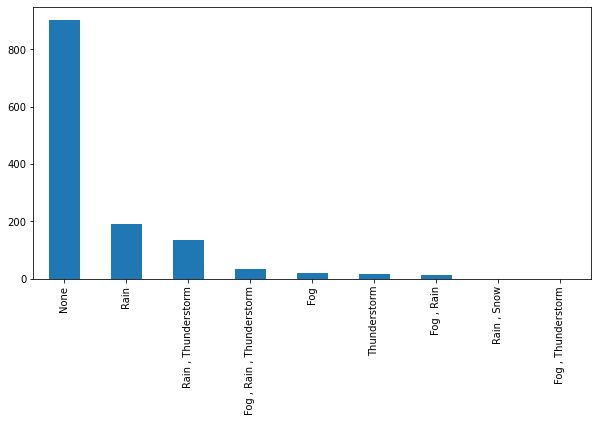

In [3]:
events.Events.value_counts().plot(kind='bar', figsize=(10,5))

We have information what events occurred for given weather parameters. 

We can see that single column combines multiple events.

Separating them seems to be a good idea as it will allow us to predict all of the events combinations independently.

Let's see what unique categories do we have in Events column:

### Get unique events categories

In [4]:
unique_events = set()
for value in events.Events.value_counts().index:
    splitted = [x.strip() for x in value.split(',')]
    unique_events.update(splitted)
unique_events

{'Fog', 'None', 'Rain', 'Snow', 'Thunderstorm'}

Now we can try to generate histogram of independent event. 

We will see that "Snow" occurred only once.

### Print histogram with single events only

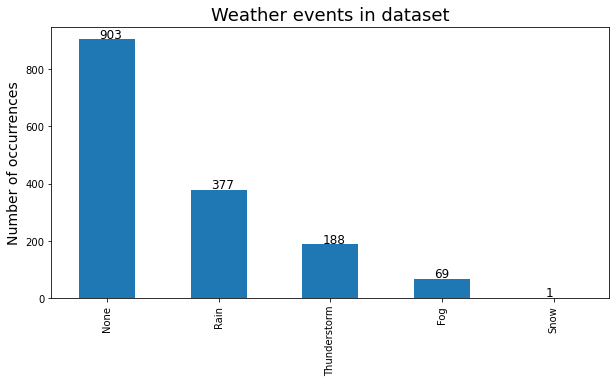

In [5]:
single_events = pd.DataFrame()
for event_type in unique_events:
    event_occurred = events.Events.str.contains(event_type)
    single_events = pd.concat([single_events, pd.DataFrame(data={event_type: event_occurred.values})], join='outer', axis=1)

#single_events.head()
ax = single_events.sum().sort_values(ascending=False).plot.bar(figsize=(10,5))
ax.set_title("Weather events in dataset", fontsize=18)
ax.set_ylabel("Number of occurrences", fontsize=14)
for i in ax.patches:
    ax.text(i.get_x()+.18, i.get_height()+5, i.get_height(), fontsize=12)

At this point we also have a nice table of predictions with events separated:

In [6]:
single_events.head()

,Rain,Thunderstorm,None,Snow,Fog
0,True,True,False,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False


During exploration I noticed that PrecipitationSumInches colum has mysterious "T" values which means "Trace". It means that there was a trace of rain but it was not measureable.

Let's check if all other values in this column are numbers or do we have anything else there:

### Check how many traces do we have in PrecipitationSumInches collumn

In [7]:
precipitation = data[pd.to_numeric(data.PrecipitationSumInches, errors='coerce').isnull()].PrecipitationSumInches.value_counts()
precipitation

T    124
Name: PrecipitationSumInches, dtype: int64

Let's check rest of the columns with non-numeric values:
### Find all non numeric rows in data frame

In [8]:
# this function returns array with one item for each row
# each item indicates if the row with columns of our interest had non-numeric data
def isColumnNotNumeric(columns_of_interest, data):
    result = np.zeros(data.shape[0], dtype=bool)
    for column_name in columns_of_interest:
        result = result | pd.to_numeric(data[column_name], errors='coerce').isnull()
    return result

def getDataFrameWithNonNumericRows(dataFrame):
    return data[isColumnNotNumeric(columns_of_interest, data)]

non_numeric_rows_count = getDataFrameWithNonNumericRows(data).shape[0]

print("Non numeric rows: {0}".format(non_numeric_rows_count))

Non numeric rows: 134


## Data transformations

### Replace "Trace" values in PrecipitationSumInches with 0 and add another column PercipitationTrace
This new column will get values 0 if there was no trace of precipitation and 1 if there was a trace

In [9]:
def numberOrZero(value):
    try:
        parsed = float(value)
        return parsed
    except:
        return 0
# this line is unnecessary if we run script from top to bottom, 
# but it helps debugging this part of code to get fresh PrecipitationSumInches column
data['PrecipitationSumInches'] = df['PrecipitationSumInches']

#Find rows indices with "T" values
has_precipitation_trace_series = isColumnNotNumeric(['PrecipitationSumInches'], data).astype(int)
#data['PrecipitationTrace'] = has_precipitation_trace_series
#data.loc[:,'PrecipitationTrace'] = has_precipitation_trace_series
data = data.assign(PrecipitationTrace=has_precipitation_trace_series.values)

data['PrecipitationSumInches'] = data['PrecipitationSumInches'].apply(numberOrZero)
data.iloc[0:10,:]

c:\users\sam\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
5,48,36,63,30.4,9,3,0.00,0
6,53,39,65,30.39,9,1,0.00,1
7,51,39,64,30.17,10,2,0.00,1
8,50,41,76,30.1,10,5,0.00,0
9,40,26,60,30.33,10,5,0.00,0


Check how many non numeric rows we still have

In [10]:
getDataFrameWithNonNumericRows(data)

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
174,79,-,75,29.95,-,4,0.0,0
175,92,-,77,29.93,-,6,0.0,0
176,83,-,-,29.9,-,9,0.0,0
177,84,-,72,29.99,-,8,0.0,1
596,89,-,65,-,-,-,0.0,0
597,90,-,62,-,-,6,0.0,0
598,90,-,-,-,-,-,0.0,0
638,82,63,60,29.96,-,3,0.0,0
639,84,64,57,29.95,-,4,0.0,0
741,46,33,60,30.48,-,8,0.0,1


As there are not so many missing values, we can drop missing data.

We need to get rows indices first to drop them as well in events table
### Drop rows with missing values

In [11]:
row_indices_for_missing_values = getDataFrameWithNonNumericRows(data).index.values
row_indices_for_missing_values
data_prepared = data.drop(row_indices_for_missing_values)
events_prepared = single_events.drop(row_indices_for_missing_values)
print("Data rows: {0}, Events rows: {1}".format(data_prepared.shape[0], events_prepared.shape[0]))

Data rows: 1307, Events rows: 1307


### Convert dataframe columns to be treated as numbers

In [12]:
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                  object
HumidityAvgPercent            object
SeaLevelPressureAvgInches     object
VisibilityAvgMiles            object
WindAvgMPH                    object
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

In [13]:
data_prepared = data_prepared.apply(pd.to_numeric)
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                   int64
HumidityAvgPercent             int64
SeaLevelPressureAvgInches    float64
VisibilityAvgMiles             int64
WindAvgMPH                     int64
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

### Normalize input data


In [14]:
from sklearn import preprocessing
data_values = data_prepared.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

data_prepared = pd.DataFrame(min_max_scaler.fit_transform(data_prepared), columns=data_prepared.columns, index=data_prepared.index)

## Final look at the  prepared data

In [15]:
data_prepared.head()

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,0.484375,0.602941,0.685714,0.109244,0.625,0.272727,0.088462,0.0
1,0.296875,0.411765,0.585714,0.487395,1.000,0.454545,0.000000,0.0
2,0.250000,0.279412,0.357143,0.789916,1.000,0.181818,0.000000,0.0
3,0.265625,0.294118,0.414286,0.756303,1.000,0.272727,0.000000,0.0
4,0.328125,0.470588,0.628571,0.655462,1.000,0.090909,0.000000,1.0


In [16]:
events_prepared.head()

,Rain,Thunderstorm,None,Snow,Fog
0,True,True,False,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False


## Train the model
### Split the data into train and test sets

In [17]:
from sklearn.model_selection import train_test_split

random_state = 42
X_train, X_test = train_test_split(data_prepared, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(events_prepared, test_size=0.2, random_state=random_state)

clusters_count = len(unique_events)

### Check if we can figure out events by discovering them using unsupervised learning techniques

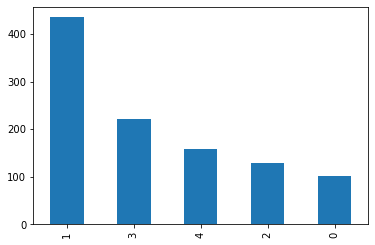

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=clusters_count).fit(X_train)

resultDf = pd.DataFrame(kmeans.labels_)
resultDf.iloc[:,0].value_counts().plot.bar()
#plt.hist(kmeans.labels_)

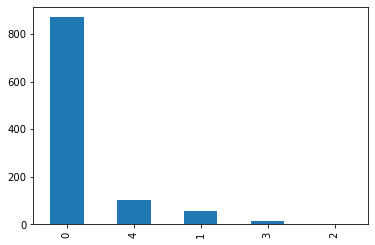

In [19]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=clusters_count, linkage="average").fit(X_train)
resultDf = pd.DataFrame(ac.labels_)
resultDf.iloc[:,0].value_counts().plot.bar()

### Ground truth

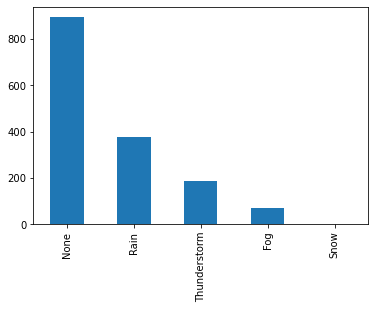

In [20]:
events_prepared.sum().sort_values(ascending=False).plot.bar()

As we can see AgglomerativeClustering did some nice work representing similar distribution of categories as for real data.

However it can output only single event so we are unable to know that there will be Rain and Fog at the same time.

## Multi-label clustering

We need to calculate cluster centers. That way, for given new sample, we can measure distance from each cluster. Using some distance threshold we will be able to assign new data to one or more clusters.

Let's have a look at these 2 charts:

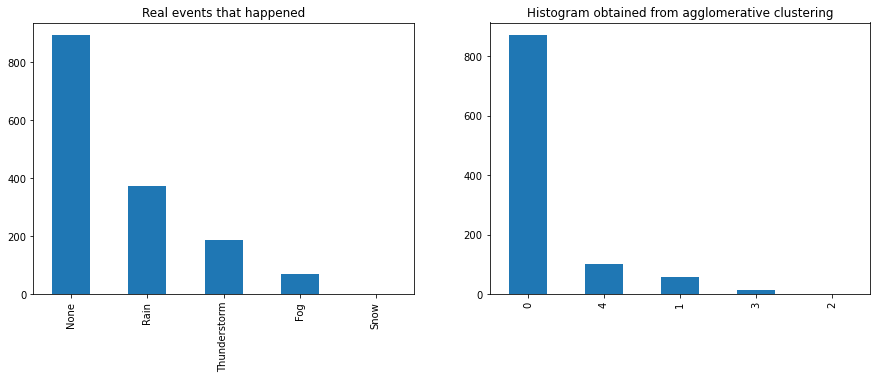

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
events_prepared.sum().sort_values(ascending=False).plot.bar(ax=ax[0], title="Real events that happened")
resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Histogram obtained from agglomerative clustering")

We can now try to map cluster numbers to category names.

In [22]:
event_names_ordered = events_prepared.sum().sort_values(ascending=False).index
clusters_ordered = resultDf.iloc[:,0].value_counts().index
cluster_category_mapping = {}
for i in range(clusters_count):
    cluster_category_mapping.update({clusters_ordered[i]:event_names_ordered[i]})
cluster_category_mapping

{0: 'None', 4: 'Rain', 1: 'Thunderstorm', 3: 'Fog', 2: 'Snow'}

## Find clusters centroids to classify test data
We need to have a way to classify new data on already trained clusters.

We can do this by calculating clusters center and measure distance from each center 

In [23]:
cluster_centers_mapping = {}
for key in cluster_category_mapping:
    cluster_indices = resultDf.loc[resultDf[0] == key].index
    cluster_data = X_train.iloc[cluster_indices]
    mean = cluster_data.mean(axis=0).values
    #print("\n" + cluster_category_mapping[key])
    #print(mean)
    cluster_centers_mapping.update({key:mean})
cluster_centers_mapping

{0: array([0.66684626, 0.71558485, 0.53737274, 0.39408867, 0.92715517,
        0.36185998, 0.01333112, 0.        ]),
 4: array([0.66259282, 0.7603378 , 0.62192362, 0.39995008, 0.9220297 ,
        0.39423942, 0.        , 1.        ]),
 1: array([0.37553879, 0.59077079, 0.81453202, 0.46479281, 0.47844828,
        0.40125392, 0.06999337, 0.        ]),
 3: array([0.690625  , 0.88431373, 0.85142857, 0.28403361, 0.46666667,
        0.44242424, 0.59641026, 0.        ]),
 2: array([0.015625  , 0.05882353, 0.3       , 0.83193277, 1.        ,
        0.36363636, 0.        , 1.        ])}

We now need to calculate distances between these centroids and our data points

In [24]:
def get_distances_from_cluster(data_frame):
    cluster_distance = np.zeros((data_frame.shape[0], clusters_count))
    #cluster_distance
    for i in range(data_frame.shape[0]):
        #print(X_test.iloc[[i]].values[0])
        for key in cluster_category_mapping:
            dist = np.linalg.norm(data_frame.iloc[[i]].values[0]-cluster_centers_mapping[key])
            cluster_distance[i,key] = dist
            #print(dist)
    column_names = [cluster_category_mapping[k] for k in cluster_category_mapping]
    #column_names

    return pd.DataFrame(cluster_distance, index=data_frame.index, columns=column_names)

distancesDf = get_distances_from_cluster(X_train)
distancesDf.head()

,None,Rain,Thunderstorm,Fog,Snow
1304,1.076076,1.362176,1.393672,1.370068,0.410872
547,0.545300,0.611610,1.757403,0.511271,1.114620
293,0.356203,0.856249,1.684327,0.875558,1.052542
10,0.771528,0.883183,1.128419,1.326534,1.298398
147,0.388148,0.800786,1.494443,0.964510,1.075485


Column with minimum distance is our classification. But to have ability to classify a record to both clusters, we can add some tolerance. 
For example 
> Data point belongs to cluster if distance from cluster is smaller than minimum distance * 1.2

In [25]:
def classify_events(distances_dataFrame):
    return distances_dataFrame.apply(lambda x: x<x.min()*1.02, axis=1)

classification_result = classify_events(distancesDf)
X_train_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_train_col_ordered = y_train.reindex(sorted(y_train.columns), axis=1)

#check if all columns and all rows are equal in both datasets
def check_accuracy(X, y):    
    comparison = X == y

    val_counts = comparison.all(axis=1).value_counts()
    percentageCorrect = val_counts.at[True] / X.shape[0] * 100
    return percentageCorrect
    

In [26]:
check_accuracy(X_train_col_ordered, y_train_col_ordered)

65.07177033492823

In [27]:
X_train_col_ordered.head()

,Fog,None,Rain,Snow,Thunderstorm
1304,False,False,False,True,False
547,True,False,False,False,False
293,False,True,False,False,False
10,False,True,False,False,False
147,False,True,False,False,False


In [28]:
y_train_col_ordered.head()

,Fog,None,Rain,Snow,Thunderstorm
1304,False,False,True,False,True
547,True,False,True,False,True
293,False,True,False,False,False
10,False,True,False,False,False
147,False,True,False,False,False


## Predicted weather events based on agglomerative clustering with unsupervised learning

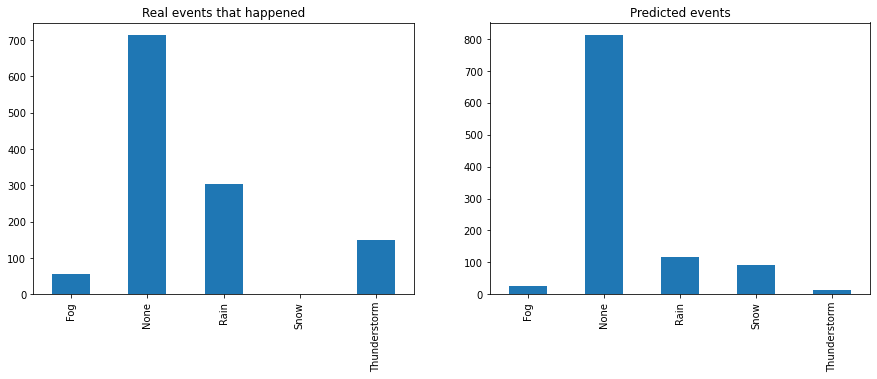

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_train_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened")
X_train_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events")
#resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Histogram obtained from agglomerative clustering")

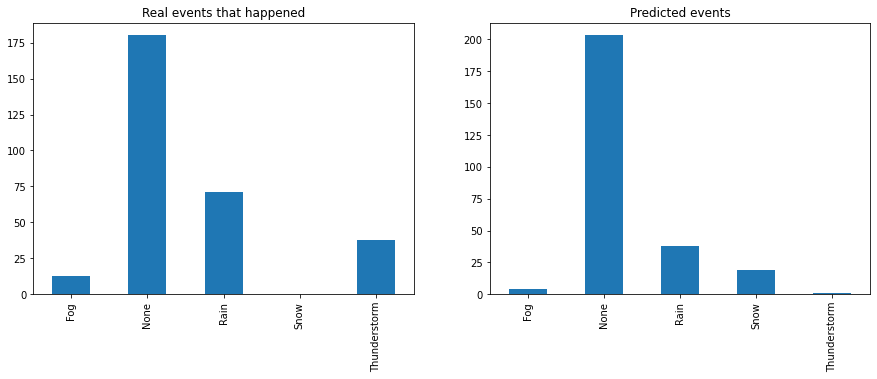

In [30]:
distancesDf = get_distances_from_cluster(X_test)
classification_result = classify_events(distancesDf)
X_test_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_test_col_ordered = y_test.reindex(sorted(y_train.columns), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_test_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened")
X_test_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events")

In [31]:
check_accuracy(X_test_col_ordered, y_test_col_ordered)

69.46564885496184